In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets.data_files import resolve_patterns_in_dataset_repository

In [117]:
def plot_model(mod, data, caption):
    age_range = np.linspace(data['age'].min(), data['age'].max(), 100)

    # Predict durations for the age range using the fitted model
    predicted_durations = mod.predict(pd.DataFrame({'age': age_range, 'age_squared': age_range**2}))
    
    # Plot the actual durations and the model estimations
    plt.figure(figsize=(10, 3))
    plt.scatter(data['age'], data['duration'], label='Actual Duration', s=2)
    plt.plot(age_range, predicted_durations, color='red', label='Model Estimation')
    plt.ylim((0.1, 0.5))
    plt.xlabel('Age')
    plt.ylabel('Median Fixation Duration')
    plt.title(f'Model Estimation vs. Actual Duration {caption}')
    plt.legend()
    plt.show()


### Fitting the GLM, checking for outliers based on residuals, trying to fit once more

In [ ]:
# load and join fixation and participant data
compiled_fixations_url = 'https://raw.githubusercontent.com/AlexeyOm/eye-tracking/refs/heads/main/compiled_fixations.csv'
participant_info_url = 'https://raw.githubusercontent.com/AlexeyOm/eye-tracking/refs/heads/main/participant_info.csv'

compiled_fixations_df = pd.read_csv(compiled_fixations_url)
participant_info_df = pd.read_csv(participant_info_url)

merged_df = pd.merge(compiled_fixations_df, participant_info_df, on='ID')

# replace date of birth with age
merged_df['age'] = 2023 - merged_df['DoB']
merged_df = merged_df.drop('DoB', axis=1)

# drop irrelevant columns
fix_df = merged_df[['ID', 'age', 'Order', 'duration', 'Valid', 'Valid Freeviewing']]

# convert column names to lowercase
fix_df.columns = fix_df.columns.str.lower()

# leaving only valid viewers
valid_fix_df = fix_df[(fix_df['valid'] == True) & (fix_df['valid freeviewing'] == True)]

# dropping default year 2000 from dataset
valid_fix_df = valid_fix_df[(valid_fix_df['age'] != 23)]

Almost 40% of data is gone if we leave the default year 2000 out.

In [9]:
(fix_df.shape[0] - valid_fix_df.shape[0])/fix_df.shape[0]

0.37251602433193376

### Fitting the GLM using Inverse Gaussian family of distribution and InversePower as link function

C:\ana3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the InverseGaussian family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                 4546
Model:                            GLM   Df Residuals:                     4543
Model Family:         InverseGaussian   Df Model:                            2
Link Function:           InversePower   Scale:                         0.28923
Method:                          IRLS   Log-Likelihood:                 7695.9
Date:                Fri, 01 Nov 2024   Deviance:                       978.91
Time:                        21:20:09   Pearson chi2:                 1.31e+03
No. Iterations:                     8   Pseudo R-squ. (CS):          0.0005853
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.7880      0.091     52.863      

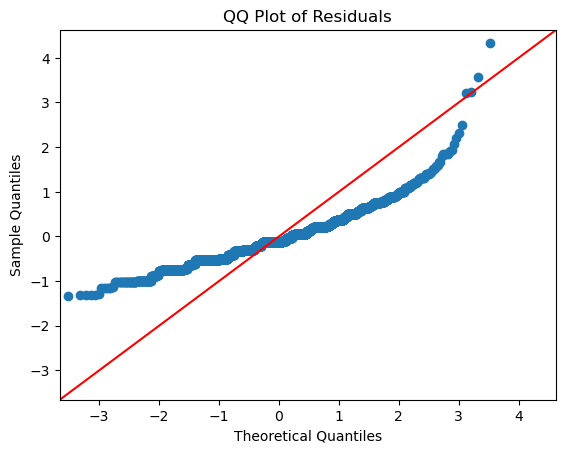

In [78]:
import statsmodels.formula.api as sm
import statsmodels.api as sma

grouped_df = valid_fix_df.groupby('id').agg({'duration': 'median', 'age': 'first'})
#grouped_df['duration'] = grouped_df['duration'] * 1000
#grouped_df['duration'] = np.log(grouped_df['duration'])
#grouped_df = grouped_df[grouped_df['age'] != 23]
#grouped_df = grouped_df[grouped_df['age'] < 66]
#grouped_df = grouped_df[grouped_df['age'] > 5]


# Fit a GLM with age and age_squared as covariates
model = sm.glm('duration ~ age + I(age**2)', data=grouped_df, family=sma.families.InverseGaussian(link=sma.families.links.InversePower())).fit()

# Print the model summary
print(model.summary())

residuals = model.resid_deviance  # Deviance residuals are often used for GLM
sma.qqplot(residuals, line='45')
plt.title('QQ Plot of Residuals')
plt.show()

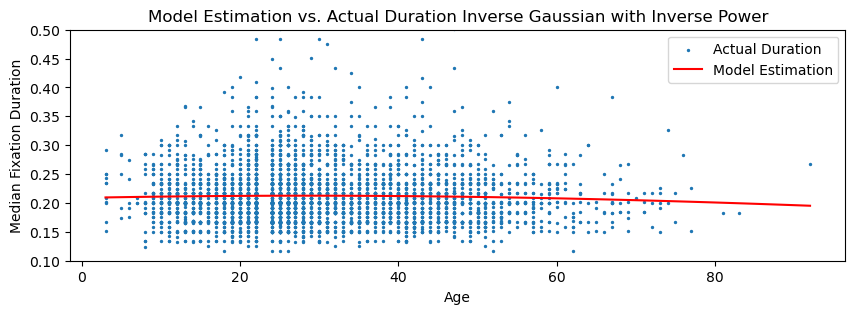

In [118]:
plot_model(model, grouped_df, "Inverse Gaussian with Inverse Power")

### Removing the high_leverage points and fitting the model again

In [85]:
influence = model.get_influence()

# Calculate leverage (hat values)
leverage = influence.hat_matrix_diag

leverage_threshold = 2 * 3 / grouped_df.shape[0]  # 2 * num of covariates with intercept / number of experiments

In [68]:
grouped_df.shape[0]

4546

In [86]:
lo_leverage_points = leverage < leverage_threshold

C:\ana3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the InverseGaussian family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                 4190
Model:                            GLM   Df Residuals:                     4187
Model Family:         InverseGaussian   Df Model:                            2
Link Function:           InversePower   Scale:                         0.23262
Method:                          IRLS   Log-Likelihood:                 7350.9
Date:                Fri, 01 Nov 2024   Deviance:                       839.23
Time:                        21:26:37   Pearson chi2:                     974.
No. Iterations:                     8   Pseudo R-squ. (CS):            0.01362
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       5.6999      0.130     43.762      

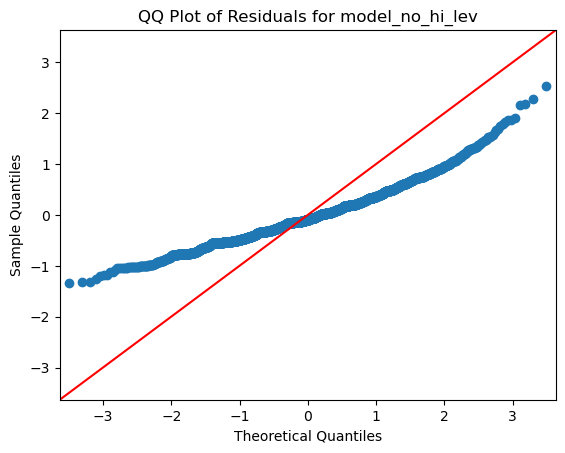

In [87]:
grouped_df_no_hi_lev = valid_fix_df.groupby('id').agg({'duration': 'median', 'age': 'first'})

grouped_df_no_hi_lev = grouped_df_no_hi_lev[lo_leverage_points]


# Fit a GLM with age and age_squared as covariates
model_no_hi_lev = sm.glm('duration ~ age + I(age**2)', data=grouped_df_no_hi_lev, family=sma.families.InverseGaussian(link=sma.families.links.InversePower())).fit()

# Print the model summary
print(model_no_hi_lev.summary())

residuals = model_no_hi_lev.resid_deviance  # Deviance residuals are often used for GLM
sma.qqplot(residuals, line='45')
plt.title('QQ Plot of Residuals for model_no_hi_lev')
plt.show()

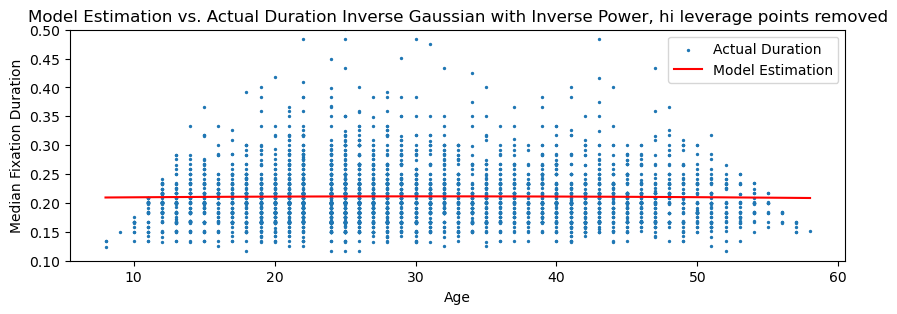

In [119]:
plot_model(model_no_hi_lev, grouped_df_no_hi_lev, "Inverse Gaussian with Inverse Power, hi leverage points removed")

Removing high_leverage_points removes too much data

## Pearson residuals

In [122]:
pearson_residuals = model.resid_pearson
# Define a threshold for outliers (e.g., ±2 or ±3)
threshold = 2  # Use ±2 or ±3 based on the desired strictness

# Identify outliers
non_outliers = np.abs(pearson_residuals) < threshold
non_outliers

id
20230314113311129    False
20230314115057038     True
20230314115611868     True
20230314120503166     True
20230314120855847     True
                     ...  
20231119170242080     True
20231121115804089     True
20231121121238463     True
20231121124149596     True
20231121131459835     True
Length: 4546, dtype: bool

C:\ana3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the InverseGaussian family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                 4521
Model:                            GLM   Df Residuals:                     4518
Model Family:         InverseGaussian   Df Model:                            2
Link Function:           InversePower   Scale:                         0.20502
Method:                          IRLS   Log-Likelihood:                 8063.2
Date:                Sat, 02 Nov 2024   Deviance:                       855.54
Time:                        11:37:34   Pearson chi2:                     926.
No. Iterations:                     8   Pseudo R-squ. (CS):          0.0003358
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       4.7936      0.077     62.643      

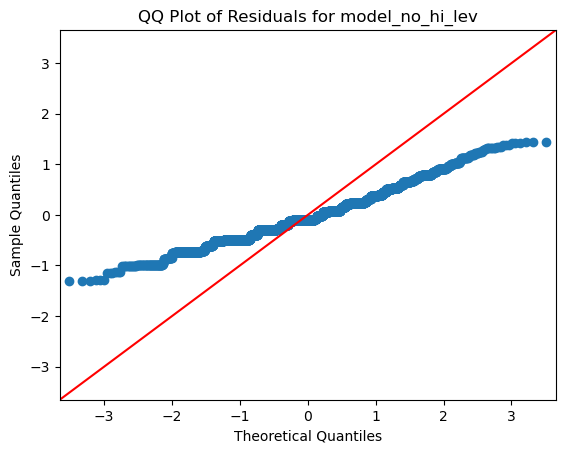

In [123]:
grouped_df_no_pearson_outliers = valid_fix_df.groupby('id').agg({'duration': 'median', 'age': 'first'})

grouped_df_no_pearson_outliers = grouped_df_no_pearson_outliers[non_outliers]


# Fit a GLM with age and age_squared as covariates
model_no_pearson_outliers = sm.glm('duration ~ age + I(age**2)', data=grouped_df_no_pearson_outliers, family=sma.families.InverseGaussian(link=sma.families.links.InversePower())).fit()

# Print the model summary
print(model_no_pearson_outliers.summary())

residuals = model_no_pearson_outliers.resid_deviance  # Deviance residuals are often used for GLM
sma.qqplot(residuals, line='45')
plt.title('QQ Plot of Residuals for model_no_hi_lev')
plt.show()

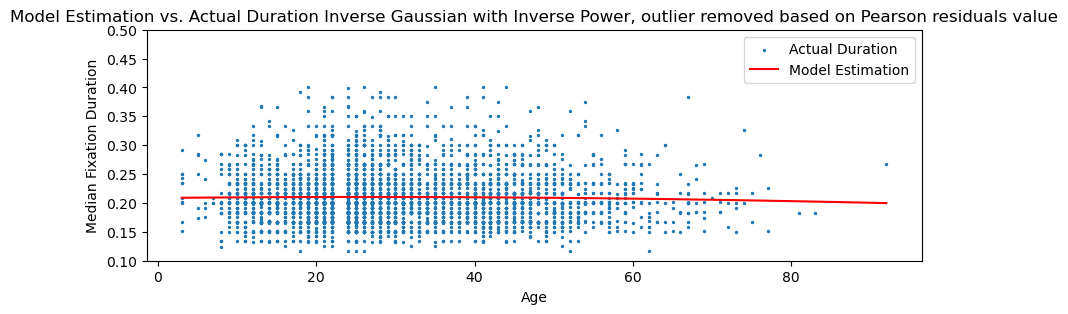

In [125]:
plot_model(model_no_pearson_outliers, grouped_df_no_pearson_outliers, "Inverse Gaussian with Inverse Power, outlier removed based on Pearson residuals value")

### Cook's distance for outlier removal

In [110]:
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]  # Extract Cook's Distance values

# Set a threshold for Cook's Distance
n = grouped_df.shape[0]
cooks_d_threshold = 4 / n

non_outliers = cooks_d > cooks_d_threshold

C:\ana3\Lib\site-packages\statsmodels\genmod\generalized_linear_model.py:307: DomainWarning: The InversePower link function does not respect the domain of the InverseGaussian family.
  warnings.warn((f"The {type(family.link).__name__} link function "


                 Generalized Linear Model Regression Results                  
Dep. Variable:               duration   No. Observations:                  190
Model:                            GLM   Df Residuals:                      187
Model Family:         InverseGaussian   Df Model:                            2
Link Function:           InversePower   Scale:                         0.29854
Method:                          IRLS   Log-Likelihood:                 189.13
Date:                Sat, 02 Nov 2024   Deviance:                       43.274
Time:                        10:55:53   Pearson chi2:                     55.8
No. Iterations:                    12   Pseudo R-squ. (CS):             0.3065
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       3.9040      0.239     16.308      

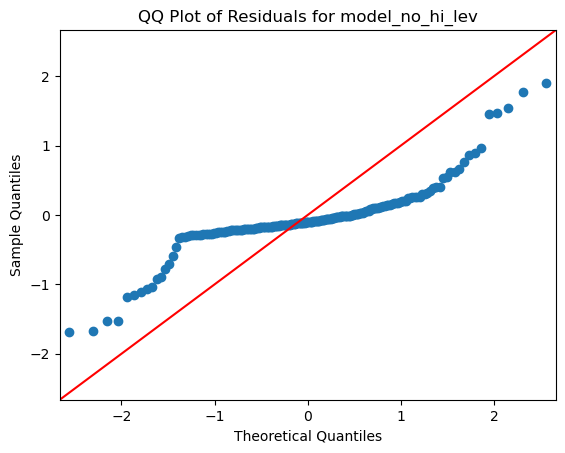

In [111]:
grouped_df_no_cooks_outliers = valid_fix_df.groupby('id').agg({'duration': 'median', 'age': 'first'})

grouped_df_no_cooks_outliers = grouped_df_no_cooks_outliers[non_outliers]


# Fit a GLM with age and age_squared as covariates
model_no_cooks_outliers = sm.glm('duration ~ age + I(age**2)', data=grouped_df_no_cooks_outliers, family=sma.families.InverseGaussian(link=sma.families.links.InversePower())).fit()

# Print the model summary
print(model_no_cooks_outliers.summary())

residuals = model_no_cooks_outliers.resid_deviance  # Deviance residuals are often used for GLM
sma.qqplot(residuals, line='45')
plt.title('QQ Plot of Residuals for model_no_hi_lev')
plt.show()

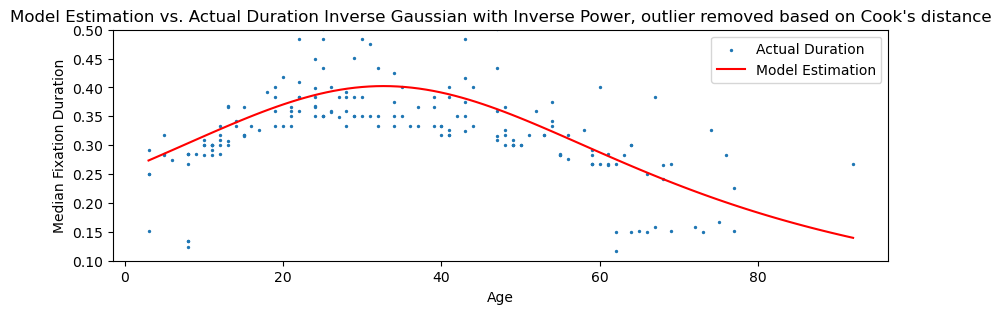

In [126]:
plot_model(model_no_cooks_outliers, grouped_df_no_cooks_outliers, "Inverse Gaussian with Inverse Power, outlier removed based on Cook's distance")

that's some nice. Unsusable, but nicedef